In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, List
import json
import pickle

import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torch.optim.lr_scheduler import OneCycleLR

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint


print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data
from transformer import LGBMLeavesEncoder, XGBLeavesEncoder, CATBLeavesEncoder

PyTorch version: 2.4.1
PyTorch Lightning version: 2.4.0


In [2]:
# set seeds for reproducibility
np.random.seed(2112)
pl.seed_everything(2112)

Seed set to 2112


2112

In [3]:
# useful callbacks
class LearningRateMonitor(pl.Callback):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if batch_idx % 100 == 0:  # Log every 100 batches
            lr = pl_module.optimizers().param_groups[0]['lr']
            pl_module.log('learning_rate', lr, prog_bar=True)   

class BestValRMSELogger(pl.Callback):
    def __init__(self):
        super().__init__()
        self.best_val_rmse = float('inf')

    def on_validation_epoch_end(self, trainer, pl_module):
        current_val_rmse = trainer.callback_metrics.get('val_rmse')
        if current_val_rmse is not None:
            self.best_val_rmse = min(self.best_val_rmse, current_val_rmse)
            pl_module.log('best_val_rmse', self.best_val_rmse, prog_bar=True)

***
### load and preprocess data

In [4]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [5]:
# Load the feature selection results
fs_type = 'full'

In [6]:
# Parameters
fs_type = "fsv2"


In [7]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 296
Categorical features: 5
Text features: 0


In [8]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=True,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 296
Categorical Columns: 5


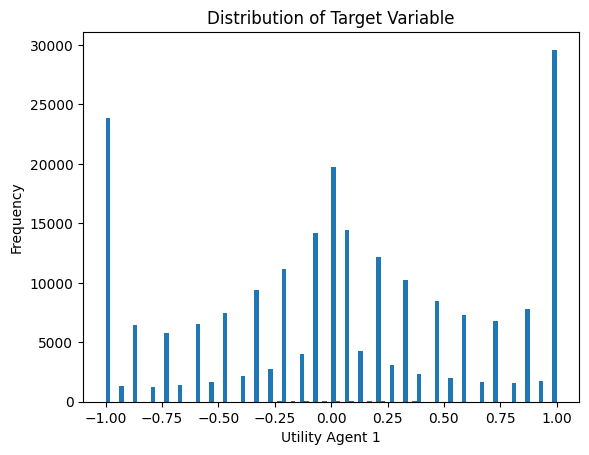

In [9]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [10]:
cat_input_dims = df_train[categorical_cols].nunique(axis=0).values.tolist()
print(cat_input_dims)

[72, 72, 4, 3, 4]


***
### train model


In [11]:
class MLP(pl.LightningModule):

    def __init__(self, 
            num_input_dim: int,
            cat_input_dims: list[int],
            output_dim: int,
            layers: str,
            dropout: float,
            embedding_dropout: float,
            learning_rate: float = 1e-3,
            weight_decay: float = 1e-5,
            initialization: str = 'kaiming_uniform',
            embedding_dim: Optional[List[int]] = None,
            pct_start: float = 0.2,
            div_factor: float = 10.0,
            final_div_factor: float = 1e4,
        ):
        super().__init__()
        self.save_hyperparameters()
        self.dropout = dropout
        self.embedding_dropout = embedding_dropout
        self.pct_start = pct_start
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor

        # Initialize embedding dimensions if not provided
        if embedding_dim is None:
            # Rule of thumb: min(50, num_unique // 2 + 1) for each categorical feature
            embedding_dim = [min(50, int(1 + np.ceil(np.sqrt(dim)))) for dim in cat_input_dims]

        elif len(embedding_dim) != len(cat_input_dims):
            raise ValueError("Length of embedding_dim must match number of categorical features.")

        self.embedding_dim = embedding_dim

        # Create embedding layers
        self.create_embeddings(cat_input_dims, embedding_dim)

        # Create backbone layers
        self.create_backbone(num_input_dim, layers)

        # Create head layers
        self.create_head(output_dim)

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.initialization = initialization

        self._init_weights()

        # Initialize lists to store validation outputs
        self.validation_targets = []
        self.validation_predictions = []

    def create_embeddings(self, cat_input_dims: list[int], embedding_dim: list[int]):
        self.embeddings = nn.ModuleList(
            [nn.Embedding(dim, emb_dim) for dim, emb_dim in zip(cat_input_dims, embedding_dim)]
        )
        self.embedding_dropout_layer = nn.Dropout(self.embedding_dropout)

    def create_backbone(self, num_input_dim: int, layers: str):
        # Calculate total input dimension after embeddings
        total_embedding_dim = sum(self.embedding_dim)
        total_input_dim = num_input_dim + total_embedding_dim

        # Parse layers string
        layer_sizes = [int(size) for size in layers.split('-')]

        # Create backbone network layers
        backbone_layers = []
        prev_size = total_input_dim
        for size in layer_sizes:
            backbone_layers.extend([
                nn.BatchNorm1d(prev_size),
                nn.Linear(prev_size, size),
                nn.ReLU(),
                nn.Dropout(self.hparams.dropout),
            ])
            prev_size = size
        self.backbone = nn.Sequential(*backbone_layers)
        self.backbone_output_size = prev_size

    def create_head(self, output_dim: int):
        # Output layer
        self.head = nn.Sequential(
            nn.BatchNorm1d(self.backbone_output_size),
            nn.Linear(self.backbone_output_size, output_dim)
        )

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if any(module is m for m in self.head.modules()):
                    nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('tanh'))
                else:
                    if self.initialization == 'kaiming_uniform':
                        nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
                    elif self.initialization == 'kaiming_normal':
                        nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
                    elif self.initialization == 'xavier_uniform':
                        nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))
                    elif self.initialization == 'xavier_normal':
                        nn.init.xavier_normal_(module.weight, gain=nn.init.calculate_gain('relu'))
                    else:
                        raise ValueError(f"Unsupported initialization method: {self.initialization}")
                
                # Initialize bias to small values
                if module.bias is not None:
                    nn.init.uniform_(module.bias, -0.1, 0.1)

    def forward(self, x_num, x_cat):
        # Process categorical variables
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        embedded = torch.cat(embedded, dim=1)
        embedded = self.embedding_dropout_layer(embedded)
        
        # Concatenate numerical and embedded categorical features
        x = torch.cat([x_num, embedded], dim=1)
        
        # Pass through backbone
        x = self.backbone(x)
        
        # Pass through head
        x = self.head(x)
        x = nn.functional.hardtanh(x)

        return x.squeeze(-1)

    def training_step(self, batch, batch_idx):
        x_num, x_cat, y = batch
        y_hat = self(x_num, x_cat)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_num, x_cat, y = batch
        y_hat = self(x_num, x_cat)
        loss = F.mse_loss(y_hat, y)
        self.log('valid_loss', loss, prog_bar=True)
        # Store targets and predictions for later use
        self.validation_targets.append(y)
        self.validation_predictions.append(y_hat)
        return loss
    
    def predict_step(self, batch, batch_idx):
        if len(batch) == 2:
            x_num, x_cat = batch
        elif len(batch) == 3:
            x_num, x_cat, _ = batch
        y_hat = self(x_num, x_cat)
        return y_hat

    def on_validation_epoch_end(self):
        # Concatenate all targets and predictions
        y = torch.cat(self.validation_targets)
        y_hat = torch.cat(self.validation_predictions)
        rmse = torch.sqrt(F.mse_loss(y_hat, y))
        self.log('val_rmse', rmse, prog_bar=True)
        # Clear the lists for next epoch
        self.validation_targets.clear()
        self.validation_predictions.clear()
                
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.learning_rate, 
            weight_decay=self.weight_decay,
        )
        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.learning_rate,
            total_steps=self.trainer.estimated_stepping_batches,
            pct_start=self.pct_start,
            div_factor=self.div_factor,
            final_div_factor=self.final_div_factor,
            anneal_strategy='cos',
            cycle_momentum=True,
            base_momentum=0.85,
            max_momentum=0.95,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
            },
        }

In [12]:
params = {
    'batch_size': 448,
    'dropout': 0.0,
    'embedding_dropout': 0.2,
    'input_layer_size': 1024,
    'n_layers': 4,
    'learning_rate': 0.0017902381479678216,
    'weight_decay': 0.0003339096474946611,
    'pct_start': 0.05,
    'div_factor': 74.0,
    'final_div_factor': 39.31519465021811
}

In [13]:
# Define the number of folds for cross-validation
split_list = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

trained_models = list()
lgbm_encoders = list()
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train  = df_train.iloc[train_index][numerical_cols + categorical_cols]
    y_train = df_train.iloc[train_index]['utility_agent1']
    X_valid = df_train.iloc[val_index][numerical_cols + categorical_cols]
    y_valid = df_train.iloc[val_index]['utility_agent1']

    lgbm_encoder = LGBMLeavesEncoder(
        num_cols=numerical_cols,
        cat_cols=categorical_cols,
        task='regression',
        n_estimators=100,
        num_leaves=63,
        random_state=2112,
        verbosity=-1,
    )
    lgbm_encoder.fit(X_train, y_train)
    X_train_leaves_lgbm = lgbm_encoder.transform(X_train, verbose=True)
    X_valid_leaves_lgbm = lgbm_encoder.transform(X_valid)
    
    X_train = pd.concat([X_train, X_train_leaves_lgbm], axis=1)
    X_valid = pd.concat([X_valid, X_valid_leaves_lgbm], axis=1) 

    _categorical_cols = (
        categorical_cols + lgbm_encoder.new_columns
    )
    _cat_input_dims = X_train[_categorical_cols].nunique(axis=0).values.tolist()

    lgbm_encoders.append(lgbm_encoder)

    train_dataset = TensorDataset(
        torch.tensor(X_train[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_train[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_train.values, dtype=torch.float32)
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=8,
        persistent_workers=True
    )

    valid_dataset = TensorDataset(
        torch.tensor(X_valid[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_valid[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_valid.values, dtype=torch.float32)
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=8,
        persistent_workers=True
    )

    # Construct the layers string based on input_layer_size and n_layers
    input_layer_size = params['input_layer_size']
    n_layers = params['n_layers']
    layers = "-".join([str(input_layer_size // (2 ** i)) for i in range(n_layers)])

    model = MLP(
        num_input_dim=len(numerical_cols),
        cat_input_dims=_cat_input_dims,
        output_dim=1,
        layers=layers,
        dropout=params['dropout'],
        embedding_dropout=params['embedding_dropout'],
        learning_rate=params['learning_rate'], 
        weight_decay=params['weight_decay'],
        initialization="kaiming_uniform",
        pct_start=params["pct_start"],
        div_factor=params["div_factor"],
        final_div_factor=params["final_div_factor"],
    )
    trainer = pl.Trainer(
        # min_epochs=10, 
        max_epochs=100, 
        # deterministic=True,
        accelerator="mps", 
        callbacks=[
            EarlyStopping(
                monitor='val_rmse',
                patience=10,
                mode='min',
                verbose=False
            ), 
            LearningRateMonitor(), 
            BestValRMSELogger(),
            ModelCheckpoint(monitor='val_rmse', mode='min', save_top_k=1),
        ],
    )
    trainer.fit(
        model, 
        train_loader,
        valid_loader,
    )

    # Load the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    model = MLP.load_from_checkpoint(best_model_path)
    trained_models.append(model)

    # Predict on validation set using trainer.predict with the prediction DataLoader
    predictions = trainer.predict(model, dataloaders=valid_loader)
    y_pred = torch.cat(predictions).squeeze().cpu().numpy()
     
    # Compute RMSE on scaled values
    y_valid = y_valid.values
    rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_valid
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred
    oof.loc[val_index, 'fold'] = fold

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

oof.to_parquet(path_results / f'oof_nn-mlp_{fs_type}_cv1.parquet', index=False)

Fold 1


Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 58.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.0 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.036     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 1 - RMSE: 0.4456602322058488
Fold 2


Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 58.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.0 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.036     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 2 - RMSE: 0.44665954138298003
Fold 3


Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 58.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.0 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.036     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 3 - RMSE: 0.440925927003543
Fold 4


Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 58.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.0 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.036     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 4 - RMSE: 0.44989669596366727
Fold 5


Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 58.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.0 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.036     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 5 - RMSE: 0.40911524790459447
List of oof scores: [0.4456602322058488, 0.44665954138298003, 0.440925927003543, 0.44989669596366727, 0.40911524790459447]
Average oof score: 0.4384515288921267


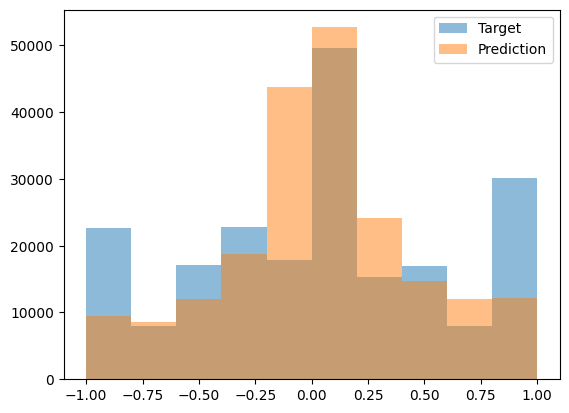

In [14]:
plt.hist(oof['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [15]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [16]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )
        
    # Initialize an array to store predictions
    predictions = np.zeros(len(test_pd))
    
    # Make predictions using each trained model
    for lgbm_encoder,model in zip(lgbm_encoders, trained_models):

        # Select relevant features
        X_test_num = test_processed[numerical_cols].copy()
        X_test_cat = test_processed[categorical_cols].copy()

        # Add LGBM encoder leaves features
        lgbm_features = lgbm_encoder.transform(
            test_processed[numerical_cols+categorical_cols]
        )
        X_test_cat = pd.concat([X_test_cat, lgbm_features], axis=1)

        model.eval()
        with torch.no_grad():
            X_test_num_tensor = torch.tensor(
                X_test_num[numerical_cols].values, dtype=torch.float32
            )
            X_test_cat_tensor = torch.tensor(
                X_test_cat[_categorical_cols].values, dtype=torch.int32
            )
            batch_predictions = model(
                X_test_num_tensor, X_test_cat_tensor
            ).cpu().numpy().flatten()

        predictions += batch_predictions
    
    # Average the predictions
    predictions /= len(trained_models)
    
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [17]:
test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(test, sample_sub)

Id,utility_agent1
i64,f64
233234,-0.001897
233235,-0.147208
233236,-0.121234


In [18]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [19]:
torch_save = {
    'models': [model.state_dict() for model in trained_models],
    'models_hparams': [model.hparams for model in trained_models],
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    '_categorical_cols': _categorical_cols,
    'encoder': encoder,
    'scaler': scaler,
    'lgbm_encoders': lgbm_encoders
}
torch.save(torch_save, f'./nn-mlp_predict_{fs_type}.pt')

***